<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training a Deep Neural Network with Time Series Data

In this lab, you will build upon the previous exercise and add more dense layers to your network. You will also look at a technique to tune the model's learning rate to make the weights converge faster. This is a useful tip so you can avoid guessing the learning rate before training.

The initial steps will be identical to the previous lab so you can run the next cells until the `Build the Model` section. That's where the discussions begin.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

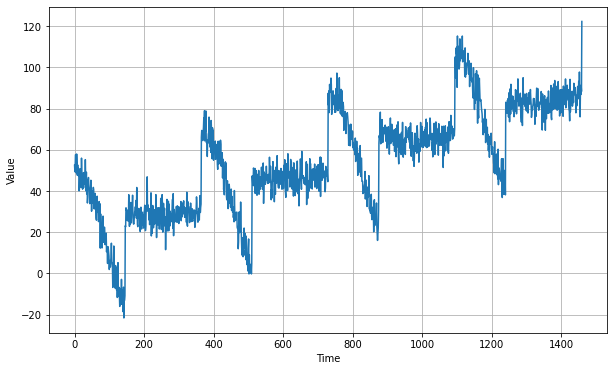

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You will use three dense layers in this exercise as shown below. As expected, the number of trainable parameters will increase and the model summary shows that it is more than tenfold of the previous lab.

In [8]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


## Train the Model

You will then compile and train the model using the same settings as before. Observe how the loss is decreasing because you will revisit it later in this lab.

In [9]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [10]:
# Train the model
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 3s 45ms/step - loss: 258.9276
Epoch 2/100
31/31 [==============================] - 1s 15ms/step - loss: 97.4962
Epoch 3/100
31/31 [==============================] - 1s 4ms/step - loss: 91.6387
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 88.1215
Epoch 5/100
31/31 [==============================] - 1s 8ms/step - loss: 84.7689
Epoch 6/100
31/31 [==============================] - 1s 7ms/step - loss: 82.7303
Epoch 7/100
31/31 [==============================] - 1s 10ms/step - loss: 80.2769
Epoch 8/100
31/31 [==============================] - 1s 5ms/step - loss: 79.0751
Epoch 9/100
31/31 [==============================] - 1s 11ms/step - loss: 76.5417
Epoch 10/100
31/31 [==============================] - 1s 10ms/step - loss: 75.1876
Epoch 11/100
31/31 [==============================] - 1s 6ms/step - loss: 74.5197
Epoch 12/100
31/31 [==============================] - 1s 4ms/step - loss: 72.7945
Epoch 13/100
31/31

You can then get some predictions and visualize it as before. Since the network is deeper, the predictions might go slower so you may want to minimize unnecessary computations. 

In the previous lab, you might remember the model generating predictions using the entire `series` data. That resulted in 1,441 points in the `forecast` list then you sliced the 461 points that aligns with the validation set using `forecast = forecast[split_time - window_size:]`. 

You can make this process faster by just generating 461 points right from the start. That way, you don't waste time predicting points that will just be thrown away later. The code below will do just that. It will just get the points needed from the original `series` before calling the `predict()` method. With that, all predictions will align with the validation set already and the for-loop will run for only 461 times instead of 1,441. 

In the next lab, you'll see an even faster way to generate these predictions.

In [ ]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

1/1 [==============================] - 0s 24ms/step


You can then get the MSE and MAE for reference.

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

## Tune the learning rate

You saw that the training went well with the initial learning rate that you chose (i.e. `1e-6`). However, you're not yet sure if it is the best setting for this particular model. It might seem inconsequential in this simple model but when you have more complex ones, spending some time to tune the learning rate can lead to better training results. You will see how to do that in this section.

First, you will build the same model architecture you just used.

In [ ]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

Next, you will declare a [learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback. This will allow you to dynamically set the learning rate based on the epoch number during training. As shown below, you will pass a lambda function to declare the value of the learning rate. It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

You will then compile the model. Just to note a subtle difference with the lecture video, you don't have to set the `learning_rate` argument of the optimizer here before compiling. You can just leave the default (i.e. [`0.01` for SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD#args)) and allow the learning rate scheduler to set it dynamically.

In [ ]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

You will pass in the `lr_schedule` callback in the `callbacks` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. As you run the training below, you will see the learning rate at a particular epoch denoted by `lr` in the console output. Notice that it is increasing as expected based on the lambda function you used.

In [ ]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Next step is to plot the results of the training. You will visualize the loss at each value of the learning rate.

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

The generated graph above shows the values of the range of learning rates that leads to lower losses (i.e. sloping downward) and also which ones cause the training to become unstable (i.e. jagged edges and pointing upwards). In general, you will want to pick a point in a downward slope. That means the network is still learning at that point and is stable. Choosing close to the minimum point of the graph will make the training converge to that loss value quicker, as will be shown in the next cells.

First, you will initialize the same model architecture again.

In [ ]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

You will then set the optimizer with a learning rate close to the minimum. It is set to `4e-6` initially but feel free to change based on your results.

In [ ]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

You can then compile and train the model as before. Observe the loss values and compare it to the output of the baseline model you had before. Most likely, you will have met the final loss value of the `model_baseline` within the first 50 epochs of training this `model_tune`. You will also likely have a lower loss after all 100 epochs are done.

In [ ]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

You can plot the `loss` values by getting it from the [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object returned by the `fit()` method. As you can see, the model is still trending downward after the training.

In [ ]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

You can get the preictions again and overlay it on the validation set.

In [ ]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

Finally, you can compute the metrics and you should arrive at similar figures compared to the baseline. If it is much worse, then the model might have overfitted and you can use techniques you know to avoid it (e.g. adding dropout).

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

## Wrap Up

This concludes the exercise on using a deep neural network for forecasting. Along the way, you did some hyperparameter tuning, particularly on the learning rate. You will be using this technique as well in the next labs. Next week, you will be using recurrent neural networks to build your forecasting model. See you there and keep it up!